## Import

In [1]:
# Tensorflow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.client import device_lib

# for keras
from classification_models.keras import Classifiers

# model
import tensorflow_addons as tfa
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# image processing, callbacks
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report

# file
import zipfile
import os
import shutil

# sub
from tqdm import tqdm
import random

# basic
import pandas as pd
import numpy as np

# Plot
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\coden\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\coden\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

In [2]:
print(tf.__version__)
print(device_lib.list_local_devices())

2.10.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 305356582984490744
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8934019072
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3230992790920102558
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b3:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 11)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## MISSION 3. Mission2에서 학습시킨 모델을 활용하여 건강관리를 위한 음식 이미지 데이터를 13개의 클래스로 분류하는 모델을 만들고, 학습 

- 해당 ipynb 파일에선 가장 좋은 성능을 보인 설정값을 기준으로 Fine-tuning을 진행했을 때 성능이 가장 높았음

#### 모델 학습 진행

In [4]:
# 데이터 폴더 경로 설정
train_data_dir = './Kfood/kfood_health_train/'  # 학습용 데이터 폴더 경로
val_data_dir = './Kfood/kfood_health_val/' # 검증용 데이터 폴더 경로

all_items = os.listdir(train_data_dir)
num_classes = len(all_items)

In [5]:
# 이미지 크기 설정
img_width, img_height = 224, 224

# 데이터 증강 설정
train_datagen = ImageDataGenerator(
    rescale=1. / 255,  # 이미지 값을 0과 1 사이로 정규화
    
    rotation_range=20,  # 2회전
    
    width_shift_range=0.2,  # 가로 이동
    height_shift_range=0.2,  # 세로 이동
    
    shear_range=0.2,  # 전단 변형
    zoom_range=0.2,  # 확대/축소
    
    horizontal_flip=True,  # 수평 뒤집기
    vertical_flip=True,  # 수직 뒤집기
    
    channel_shift_range=40,  # 채널 시프트
)

val_datagen = ImageDataGenerator(
    rescale=1. / 255, # 이미지 값을 0과 1 사이로 정규화
)

In [6]:
# 학습용 데이터 로딩 및 전처리
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical', # 다중 클래스 분류를 위해 categorical로 설정  
)

validation_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical')

Found 14115 images belonging to 13 classes.
Found 1764 images belonging to 13 classes.


In [ ]:
# Classifiers에서 제공되는 모델 목록 확인
model_list = Classifiers.models_names()

In [9]:
ResNet101, preprocess_input = Classifiers.get('resnet101')
resnet101_model = ResNet101((img_height, img_width, 3), 
                 activation = 'softmax',
                 pretrained = False,
                 include_top = False,
                 pretrained_top = False,
                 classes = num_classes)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# 체크포인트 파일 경로 및 설정
checkpoint_filepath = './Checkpoint/Mission3.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,  # 최상의 모델만 저장
    monitor='val_top_k_categorical_accuracy',
    mode='max',
    verbose=1
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 모니터링
    factor=0.2,  # 학습률을 0.2배로 줄임
    patience=5,  # 5 에폭 동안 검증 손실이 감소하지 않으면 학습률을 조절
    min_lr=1e-6  # 학습률의 하한 설정
)

# 전이 학습을 수행
with tf.device('/device:GPU:0'):
    history = transferred_model.fit(
        train_generator,
        epochs=50,
        verbose=1,
        validation_data=validation_generator,
        callbacks=[model_checkpoint_callback, reduce_lr_callback]
    )

Epoch 1/50
442/442 [==============================] - ETA: 0s - loss: 1.6438 - top_k_categorical_accuracy: 0.6707
Epoch 1: val_top_k_categorical_accuracy improved from -inf to 0.82823, saving model to ./Checkpoint\Mission3_No_layer_freeze.h5
442/442 [==============================] - 259s 547ms/step - loss: 1.6438 - top_k_categorical_accuracy: 0.6707 - val_loss: 1.3760 - val_top_k_categorical_accuracy: 0.8282 - lr: 1.0000e-04
Epoch 2/50
442/442 [==============================] - ETA: 0s - loss: 1.2533 - top_k_categorical_accuracy: 0.8691
Epoch 2: val_top_k_categorical_accuracy improved from 0.82823 to 0.89909, saving model to ./Checkpoint\Mission3_No_layer_freeze.h5
442/442 [==============================] - 183s 413ms/step - loss: 1.2533 - top_k_categorical_accuracy: 0.8691 - val_loss: 1.2076 - val_top_k_categorical_accuracy: 0.8991 - lr: 1.0000e-04
Epoch 3/50
442/442 [==============================] - ETA: 0s - loss: 1.1918 - top_k_categorical_accuracy: 0.8975
Epoch 3: val_top_k_cate

In [11]:
loss, top_k_categorical_accuracy, val_loss, val_top_k_categorical_accuracy, lr = history.history.values()

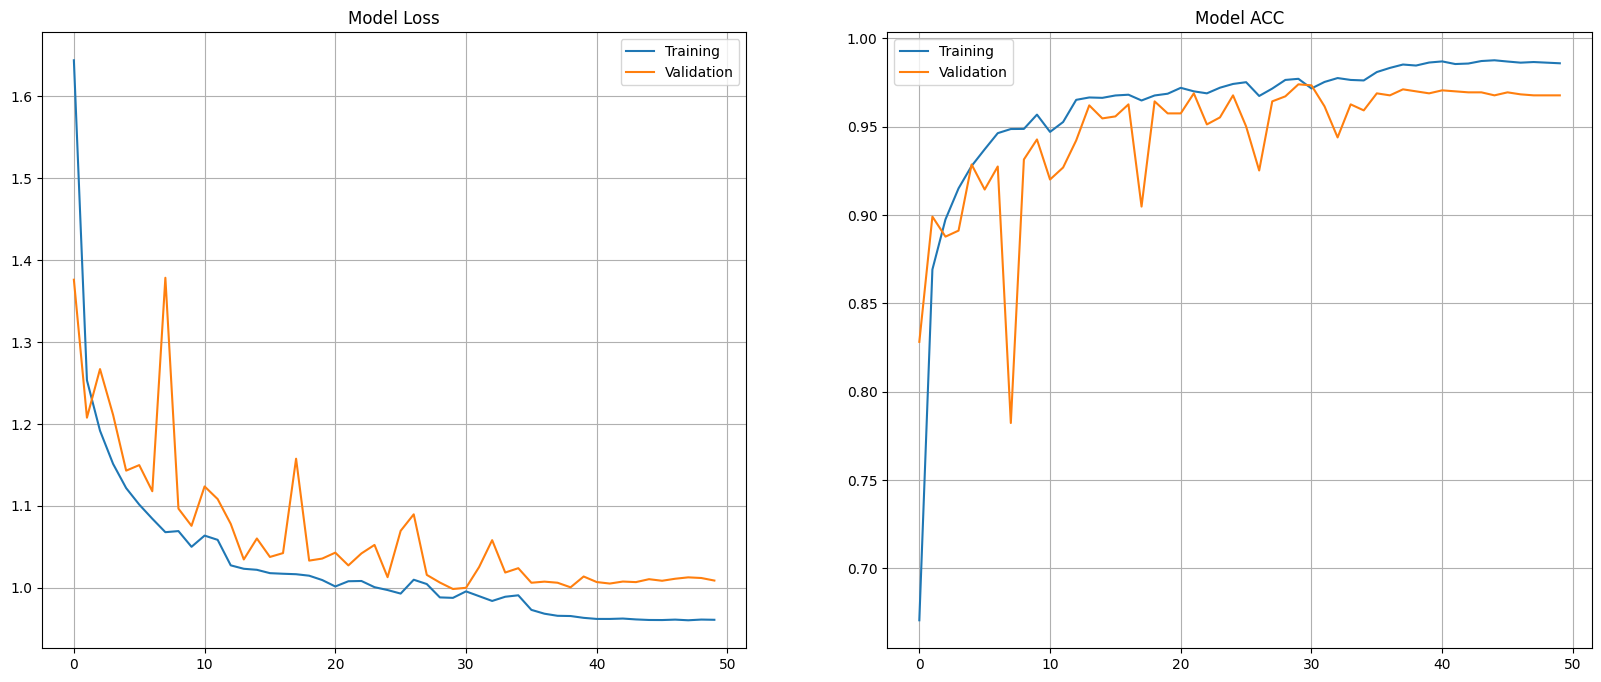

In [12]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validation")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.title("Model ACC")
plt.plot(top_k_categorical_accuracy, label="Training")
plt.plot(val_top_k_categorical_accuracy, label="Validation")
plt.legend()
plt.grid()

plt.show()

In [ ]:
# 체크포인트 파일 경로
checkpoint_filepath = './Checkpoint/Mission3_VIT_zoom.h5'

# 미션 1 모델 로드
loaded_model = load_model(checkpoint_filepath)

# 데이터 제너레이터 설정
train_data_dir = './Kfood/Kfood/kfood_health_train/' 

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255
    ) 

# 이미지 크기 설정
img_width, img_height = 224, 224

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

In [ ]:
with tf.device('/device:GPU:0'): 
    train_predict = loaded_model.predict(train_generator)

train_pred_classes = np.argmax(train_predict,axis=1)

# classification report 출력
target_names = list(train_generator.class_indices.keys())

results = pd.DataFrame(classification_report(train_generator.classes, train_pred_classes, target_names=target_names, output_dict=True)).transpose()
print(results)

14115/14115 [==============================] - 383s 27ms/step
              precision    recall  f1-score       support
가리비            0.992611  0.969916  0.981132    831.000000
갈비찜            0.952995  0.816101  0.879252   1267.000000
고등어            0.983264  0.998301  0.990725   1177.000000
김치국            0.993574  1.000000  0.996777   1237.000000
낚지볶음           1.000000  0.975775  0.987739   1032.000000
돼지갈비찜          0.790547  0.957351  0.865990    891.000000
된장찌개           1.000000  0.992639  0.996306    951.000000
떡국             0.996891  1.000000  0.998443    962.000000
모듬초밥           0.989744  0.998276  0.993991   1160.000000
배추김치           0.998068  0.993269  0.995663   1040.000000
부대찌개           0.998711  0.999355  0.999033   1551.000000
순대             0.998830  0.988426  0.993601    864.000000
오리로스구이         0.982067  0.998264  0.990099   1152.000000
accuracy       0.975062  0.975062  0.975062      0.975062
macro avg      0.975177  0.975975  0.974519  14115.000000
weighted a

#### 검증 데이터에 대한 평가 진행

In [7]:
# 체크포인트 파일 경로
checkpoint_filepath = './Checkpoint/Mission3_VIT_zoom.h5'

# 모델 로드
loaded_model = load_model(checkpoint_filepath)

# 검증용 데이터 제너레이터 설정
val_data_dir = './Kfood/Kfood/kfood_health_val/'

validation_datagen = ImageDataGenerator(rescale=1.0 / 255) 

# 이미지 크기 설정
img_width, img_height = 224, 224

validation_generator = validation_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 1764 images belonging to 13 classes.


In [8]:
import numpy as np
with tf.device('/device:GPU:0'): 
    validation_predict = loaded_model.predict(validation_generator)


from sklearn.metrics import classification_report

validation_pred_classes = np.argmax(validation_predict,axis=1)

# classification report 출력
target_names = list(validation_generator.class_indices.keys())


validation_results = pd.DataFrame(classification_report(validation_generator.classes, validation_pred_classes, target_names=target_names, output_dict=True)).transpose()
print(validation_results)

1764/1764 [==============================] - 49s 27ms/step
              precision    recall  f1-score      support
가리비            1.000000  0.970874  0.985222   103.000000
갈비찜            0.945736  0.807947  0.871429   151.000000
고등어            0.985612  1.000000  0.992754   137.000000
김치국            0.988024  1.000000  0.993976   165.000000
낚지볶음           1.000000  0.975410  0.987552   122.000000
돼지갈비찜          0.808000  0.943925  0.870690   107.000000
된장찌개           1.000000  0.990826  0.995392   109.000000
떡국             1.000000  1.000000  1.000000   118.000000
모듬초밥           0.975610  0.993789  0.984615   161.000000
배추김치           0.992248  1.000000  0.996109   128.000000
부대찌개           0.995370  1.000000  0.997680   215.000000
순대             0.988235  0.965517  0.976744    87.000000
오리로스구이         0.975758  1.000000  0.987730   161.000000
accuracy       0.973923  0.973923  0.973923     0.973923
macro avg      0.973430  0.972945  0.972299  1764.000000
weighted avg   0.975325  0.97

In [17]:
def plot_f1_score_by_class(ax, results, title, label, line_value=None):
    ax.bar(results.index, results['f1-score'], color=colors)
    ax.set_xlabel('Class')
    ax.set_ylabel('f1-score')
    ax.set_title(title)
    ax.set_xticklabels(results.index, rotation=90)
    ax.set_ylim(0, 1)
    
    if line_value is not None:
        ax.axhline(y=line_value, color='red', linestyle='--', label=label)

C:\Users\coden\AppData\Local\Temp\ipykernel_16256\143321388.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(results.index, rotation=90)


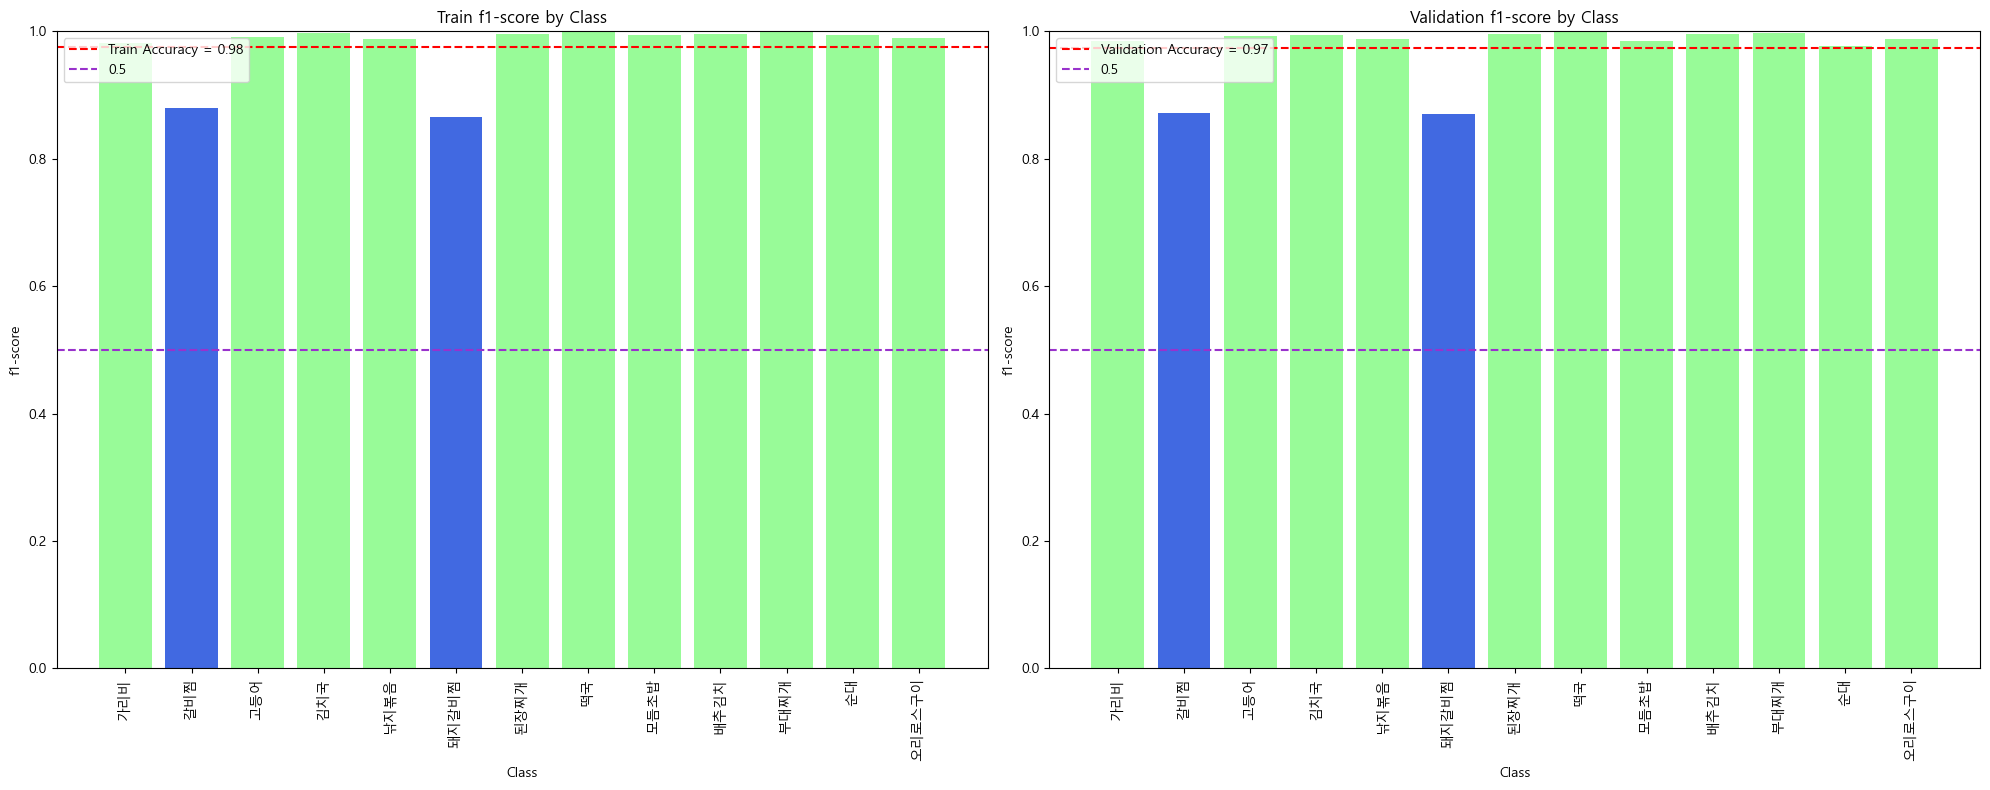

In [21]:
plt.rcParams['font.family'] = 'Malgun Gothic'

plt.figure(figsize=(20, 8))

# Train 
ax1 = plt.subplot(1, 2, 1)
colors = ['palegreen' if score >= results.iloc[-3, 2] else 'royalblue' if score >= 0.5 else 'tomato' for score in results['f1-score']]
plot_f1_score_by_class(ax1, results.iloc[:-3,:], 'Train f1-score by Class', f'Train Accuracy = {results.iloc[-3, 2]:.2f}', results.iloc[-3, 2])
ax1.axhline(y=0.5, color='darkorchid', linestyle='--', label='0.5')
ax1.legend()

# Valid
ax2 = plt.subplot(1, 2, 2)
colors = ['palegreen' if score >= validation_results.iloc[-3, 2] else 'royalblue' if score >= 0.5 else 'tomato' for score in validation_results['f1-score']]
plot_f1_score_by_class(ax2, validation_results.iloc[:-3,:], 'Validation f1-score by Class', f'Validation Accuracy = {validation_results.iloc[-3, 2]:.2f}', validation_results.iloc[-3, 2])
ax2.axhline(y=0.5, color='darkorchid', linestyle='--', label='0.5')
ax2.legend()

plt.tight_layout()
plt.show()